In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cryptoaml.datareader as cdr
from statsmodels.tsa.stattools import adfuller

In [2]:
elliptic = cdr.get_data("elliptic")
elliptic_data = elliptic.train_test_split(train_size=0.7, feat_set="AF_NE")

In [3]:
train_X = elliptic_data.train_X
train_y = elliptic_data.train_y
test_X = elliptic_data.test_X
test_y = elliptic_data.test_y
train_X["class"] = train_y
test_X["class"]  = test_y
elliptic_data = train_X.append(test_X, ignore_index=True).sort_values(by=["ts"])

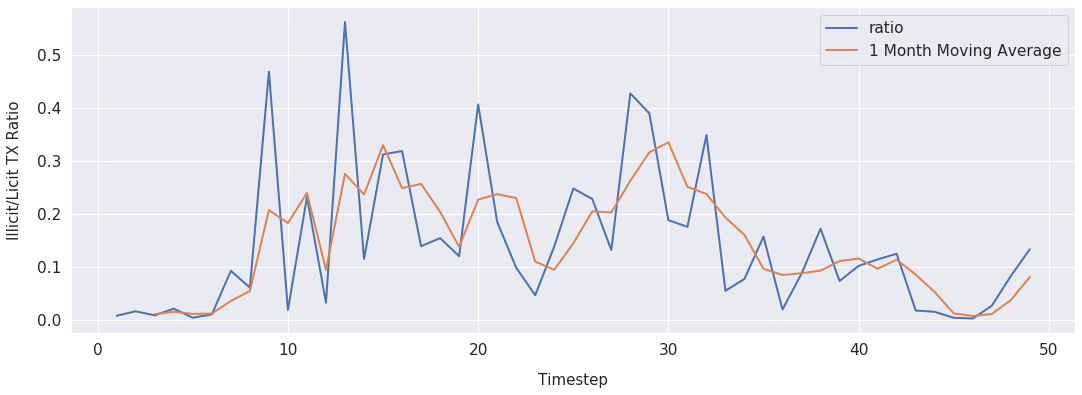

In [4]:
# plot illicit to licit transactions across timesteps 

# compute ratio for each timestep
ratio_list = []
for ts, group in elliptic_data.groupby("ts"):
    tmp_dict = {**{"ts": ts}, **group["class"].value_counts().to_dict()}
    ratio_list.append(tmp_dict)

sns.set(font_scale=1.4)
ratio_df = pd.DataFrame(data=ratio_list)
ratio_df["ratio"] = ratio_df[1] / ratio_df[0]
ratio_df.set_index("ts")["ratio"].plot(figsize=(18, 6), linewidth=2)
plt.xlabel("Timestep", labelpad=15, fontsize=15)

# moving average ration every 1 month 
ratio_df["avg"] = ratio_df["ratio"].rolling(window=3).mean()
ratio_df.set_index("ts")["avg"].plot(figsize=(18, 6), linewidth=2)
plt.xlabel("Timestep", labelpad=15, fontsize=15)
plt.ylabel("Illicit/Licit TX Ratio", labelpad=15, fontsize=15)
plt.legend(["ratio", "1 Month Moving Average"])

In [5]:
# get feature names
features = elliptic.feature_cols_AF_[1:]

# compute mean/std of each feature for all licit transactions 
elliptic_data_licit = elliptic_data[elliptic_data["class"] == 0]
elliptic_data_licit_mean = elliptic_data_licit.groupby("ts").mean()
elliptic_data_licit_std = elliptic_data_licit.groupby("ts").std()

# compute mean/std of each feature for all illicit transactions 
elliptic_data_illicit = elliptic_data[elliptic_data["class"] == 1]
elliptic_data_illicit_mean = elliptic_data_illicit.groupby("ts").mean()
elliptic_data_illicit_std = elliptic_data_illicit.groupby("ts").std()

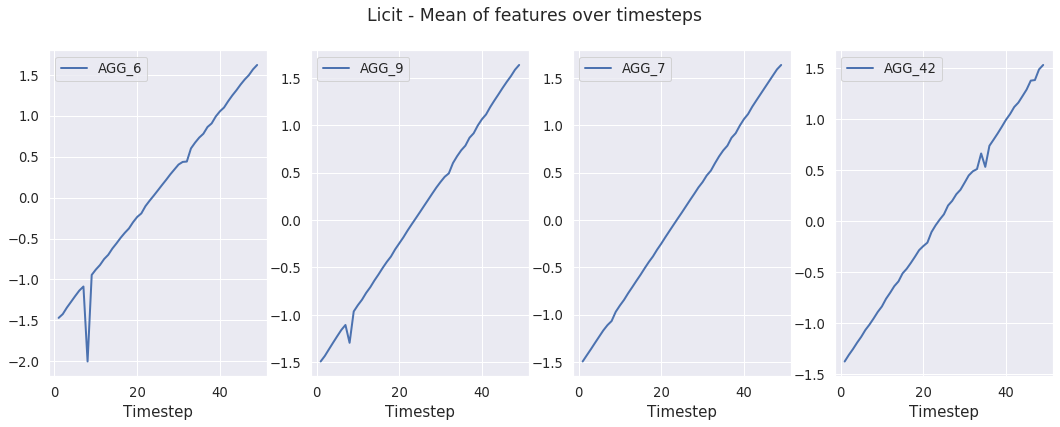

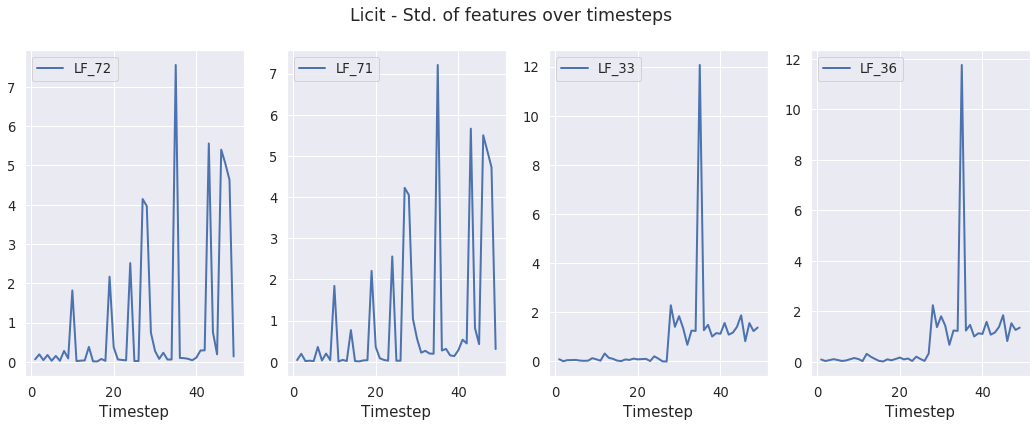

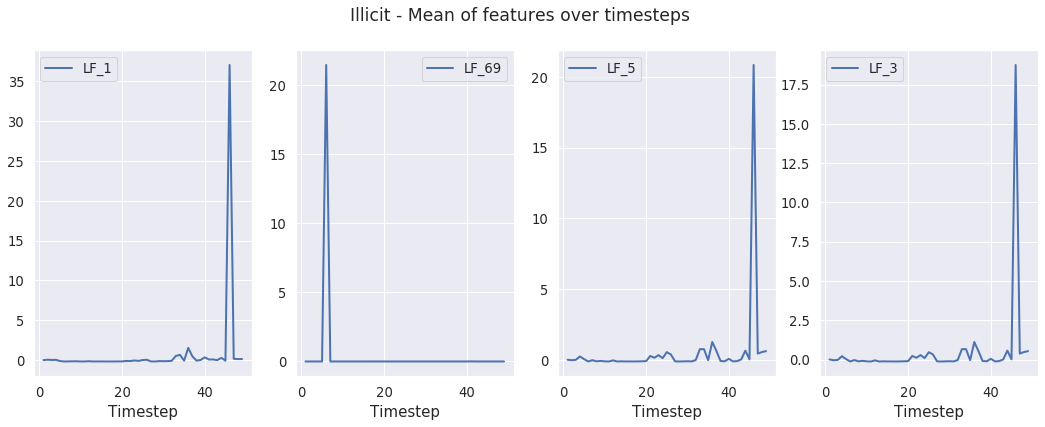

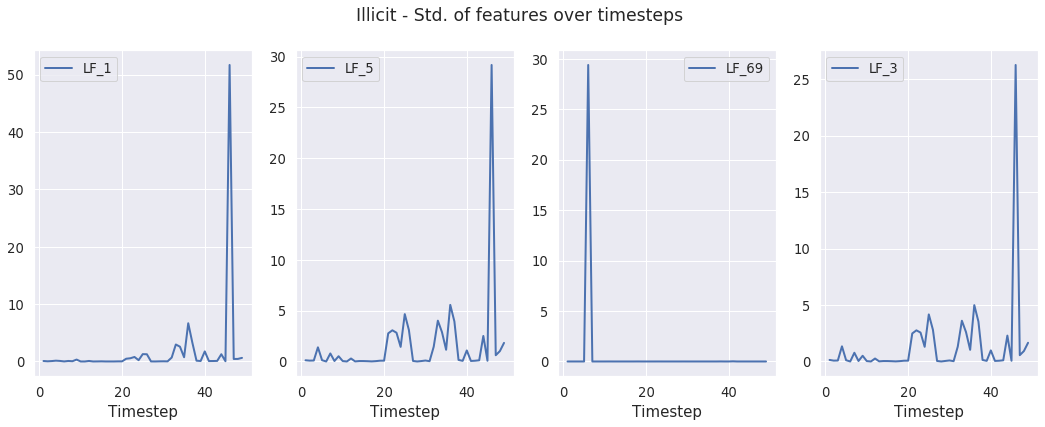

In [6]:
def plot_stationarity(data, title, save=False, save_file=""):
    sns.set(font_scale=1.2)
    counter = 0 
    top_in_variance = data[features].var().sort_values(ascending=False).head(4).index.tolist()   
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(5, 3))
    for f in top_in_variance: 
        data[f].plot(figsize=(18, 6), linewidth=2, ax=axes[counter])
        axes[counter].set_xlabel("Timestep", labelpad=5, fontsize=15)
#         axes[counter].set_ylabel(f, labelpad=5, fontsize=15)
        axes[counter].legend([f])
        counter= counter + 1
    plt.suptitle(title)
    if save == True: 
        plt.savefig(save_file)
    plt.show()

plot_stationarity(elliptic_data_licit_mean, "Licit - Mean of features over timesteps") 
plot_stationarity(elliptic_data_licit_std, "Licit - Std. of features over timesteps")
plot_stationarity(elliptic_data_illicit_mean, "Illicit - Mean of features over timesteps")
plot_stationarity(elliptic_data_illicit_std, "Illicit - Std. of features over timesteps")

In [7]:
# ADF test for licit transactions 
licit_pvalues = []
features = elliptic.feature_cols_AF_[1:]
for f in features: 
    X = elliptic_data_licit_mean[f].values
    tmp_result = adfuller(X) 
    p_value = tmp_result[1]
    licit_pvalues.append({"feature": f, "pvalue": p_value})

In [11]:
licit_pvalues_df = pd.DataFrame(licit_pvalues)
licit_pvalues_failreject = licit_pvalues_df[licit_pvalues_df["pvalue"] > 0.05]
print("Total tests which failed to reject the null hypothesis: {}".format(licit_pvalues_failreject.shape[0]))
display(licit_pvalues_failreject.sort_values(["pvalue"], ascending=False).head(10).round(3))

licit_pvalues_reject = licit_pvalues_df[licit_pvalues_df["pvalue"] <= 0.05]
print("Total tests which reject the null hypothesis: {}".format(licit_pvalues_reject.shape[0]))

Total tests which failed to reject the null hypothesis: 61


,feature,pvalue
119,AGG_26,0.985
135,AGG_42,0.973
102,AGG_9,0.959
99,AGG_6,0.947
100,AGG_7,0.939
154,AGG_61,0.854
65,LF_65,0.827
59,LF_59,0.827
66,LF_66,0.818
60,LF_60,0.818


Total tests which reject the null hypothesis: 104


In [9]:
# ADF test for illicit transactions 
illicit_pvalues = []
for f in features: 
    X = elliptic_data_illicit_mean[f].values
    tmp_result = adfuller(X) 
    p_value = tmp_result[1]
    illicit_pvalues.append({"feature": f, "pvalue": p_value})

In [12]:
illicit_pvalues_df = pd.DataFrame(illicit_pvalues)
illicit_pvalues_failreject = illicit_pvalues_df[illicit_pvalues_df["pvalue"] > 0.05]
print("Total tests which failed to reject the null hypothesis: {}".format(illicit_pvalues_failreject.shape[0]))
display(illicit_pvalues_failreject.sort_values(["pvalue"], ascending=False).head(10).round(3))

illicit_pvalues_reject = illicit_pvalues_df[illicit_pvalues_df["pvalue"] <= 0.05]
print("Total tests which reject the null hypothesis: {}".format(illicit_pvalues_reject.shape[0]))

Total tests which failed to reject the null hypothesis: 49


,feature,pvalue
1,LF_1,1.000
131,AGG_38,1.000
126,AGG_33,1.000
124,AGG_31,1.000
107,AGG_14,1.000
130,AGG_37,0.999
3,LF_3,0.999
5,LF_5,0.999
95,AGG_2,0.996
148,AGG_55,0.995


Total tests which reject the null hypothesis: 116
